<h2>LANL Earthquake Prediction</h2>

In [1]:
import os
import time
import random
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
# Sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import NuSVR, SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
import lightgbm as lgb
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
sns.set()
init_notebook_mode(connected=True)

In [13]:
from scipy import stats
import numba
import warnings
sns.set()
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

@numba.jit
def get_stats(arr):
    """Memory efficient stats (min, max and mean). """
    size  = len(arr)
    min_value = max_value = arr[0]
    mean_value = 0
    for i in numba.prange(size):
        if arr[i] < min_value:
            min_value = arr[i]
        if arr[i] > max_value:
            max_value = arr[i]
        mean_value += arr[i]
    return min_value, max_value, mean_value/size

@numba.jit
def get_diff(arr, threshold):
    """Find uniques ttf differences between rows. """
    diff_list = []
    size  = len(arr)
    uniques = 0
    for i in numba.prange(size - 1):
        diff = abs(arr[i+1] - arr[i])
        if uniques == 0:
            diff_list.append(diff)
            uniques += 1
        else:
            for j in numba.prange(uniques):
                if abs(diff - diff_list[j]) < threshold or abs(diff - diff_list[j]) > 1:
                    break
            else:
                diff_list.append(diff)
                uniques += 1
    return diff_list

In [2]:
data_type = {'acoustic_data': np.int16, 'time_to_failure': np.float64}
train = pd.read_csv('train.csv', dtype=data_type)
train.head()

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


<h2>1. Basic EDA</h2>
<h3>1.1 Acoustic Data</h3>

In [4]:
pd.set_option("display.precision", 8)
train.acoustic_data.describe()

count    6.29145480e+08
mean     4.51946757e+00
std      1.07357072e+01
min     -5.51500000e+03
25%      2.00000000e+00
50%      5.00000000e+00
75%      7.00000000e+00
max      5.44400000e+03
Name: acoustic_data, dtype: float64

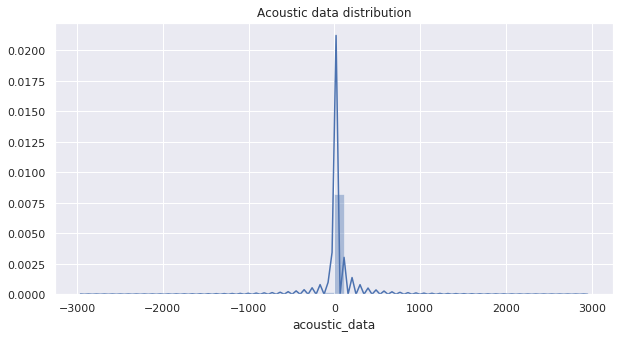

In [5]:
train_sample = train.sample(frac=0.01)
plt.figure(figsize=(10,5))
plt.title("Acoustic data distribution")
ax = sns.distplot(train_sample.acoustic_data, label='Train (1% sample)')

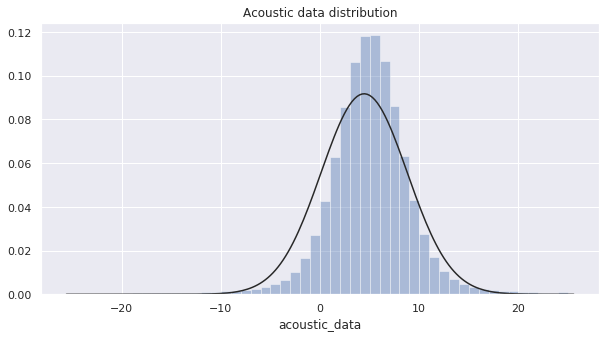

In [14]:
train_sample = train.sample(frac=0.01)
plt.figure(figsize=(10,5))
plt.title("Acoustic data distribution")
tmp = train_sample.acoustic_data[train_sample.acoustic_data.between(-25, 25)]
ax = sns.distplot(tmp, label='Train (1% sample)', kde=False, fit=stats.norm)

<h3>1.2 Time to Failure</h3>


In [17]:
tmin, tmax, tmean = get_stats(train.time_to_failure.values)
print("min value: {:.6f}, max value: {:.2f}, mean: {:.4f}".format(tmin, tmax, tmean))

min value: 0.000096, max value: 16.11, mean: 5.6783


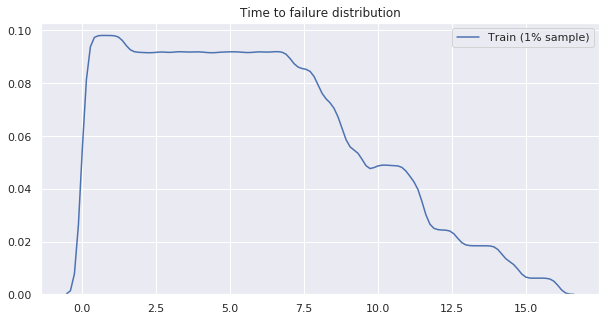

In [28]:
plt.figure(figsize=(10,5))
plt.title("Time to failure distribution")
ax = sns.kdeplot(train_sample.time_to_failure, label='Train (1% sample)')

<h3>1.3 Timeseries</h3>

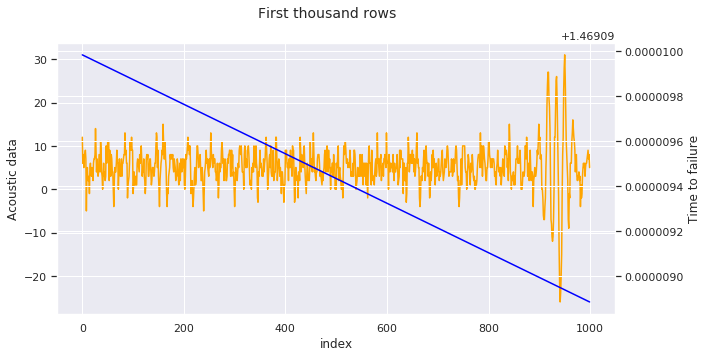

In [18]:
def single_timeseries(final_idx, init_idx=0, step=1, title="",
                      color1='orange', color2='blue'):
    idx = [i for i in range(init_idx, final_idx, step)]
    fig, ax1 = plt.subplots(figsize=(10, 5))
    fig.suptitle(title, fontsize=14)
    
    ax2 = ax1.twinx()
    ax1.set_xlabel('index')
    ax1.set_ylabel('Acoustic data')
    ax2.set_ylabel('Time to failure')
    p1 = sns.lineplot(data=train.iloc[idx].acoustic_data.values, ax=ax1, color=color1)
    p2 = sns.lineplot(data=train.iloc[idx].time_to_failure.values, ax=ax2, color=color2)


def double_timeseries(final_idx1, final_idx2, init_idx1=0, init_idx2=0, step=1, title=""):
    idx1 = [i for i in range(init_idx1, final_idx1, step)]
    idx2 = [i for i in range(init_idx2, final_idx2, step)]
    
    fig, (ax1a, ax2a) = plt.subplots(1,2, figsize=(12,5))
    fig.subplots_adjust(wspace=0.4)
    ax1b = ax1a.twinx()
    ax2b = ax2a.twinx()
    
    ax1a.set_xlabel('index')
    ax1a.set_ylabel('Acoustic data')
    ax2a.set_ylabel('Time to failure')
    p1 = sns.lineplot(data=train.iloc[idx1].acoustic_data.values, ax=ax1a, color='orange')
    p2 = sns.lineplot(data=train.iloc[idx1].time_to_failure.values, ax=ax1b, color='blue')
    
    p3 = sns.lineplot(data=train.iloc[idx2].acoustic_data.values, ax=ax2a, color='orange')
    p4 = sns.lineplot(data=train.iloc[idx2].time_to_failure.values, ax=ax2b, color='blue')
    
single_timeseries(1000, title="First thousand rows")

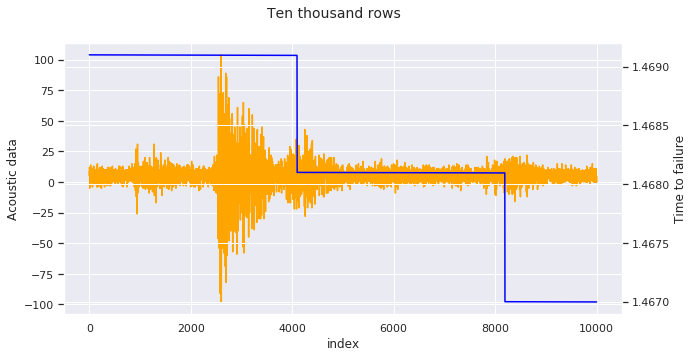

In [12]:
single_timeseries(10000, title="Ten thousand rows")

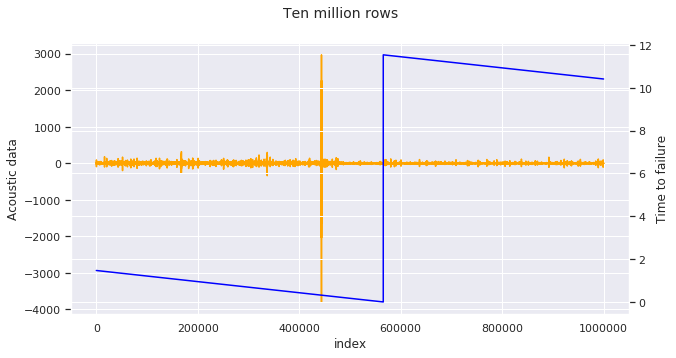

In [19]:
single_timeseries(10000000, step=10, title="Ten million rows")

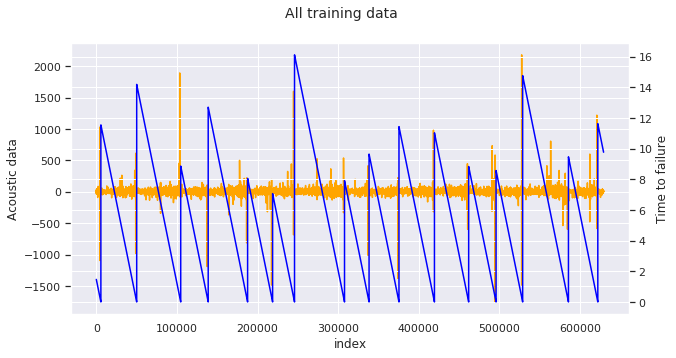

In [22]:
single_timeseries(629145000, step=1000, title="All training data")

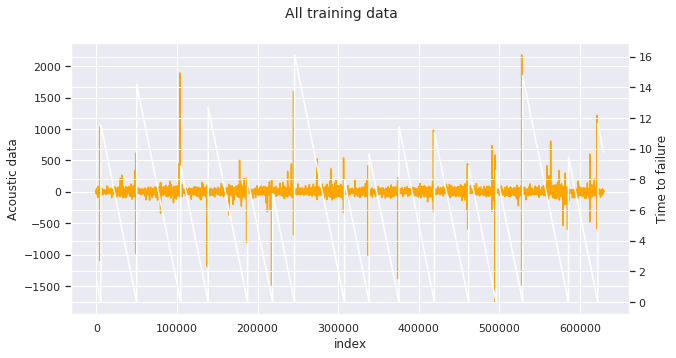

In [23]:
single_timeseries(629145000, step=1000, title="All training data",color2='white')

In [24]:
peaks = train[train.acoustic_data.abs() > 500]
peaks.time_to_failure.describe()

count    29929.00000000
mean         1.02975507
std          1.89340735
min          0.30979992
25%          0.31549715
50%          0.31859690
75%          0.32149563
max          9.77879575
Name: time_to_failure, dtype: float64

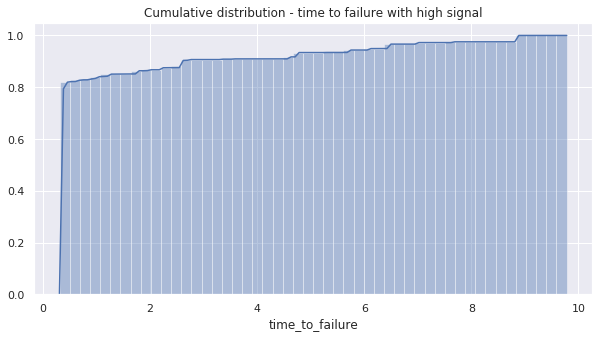

In [29]:
plt.figure(figsize=(10,5))
plt.title("Cumulative distribution - time to failure with high signal")
ax = sns.distplot(peaks.time_to_failure, hist_kws=dict(cumulative=True), kde_kws=dict(cumulative=True))

<h3>1.4 Time between measurements</h3>

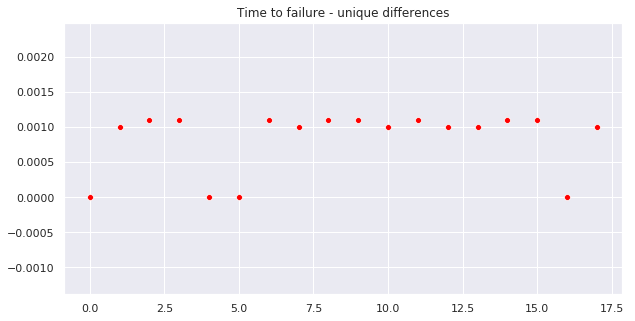

In [25]:
unique_diff = get_diff(train.time_to_failure.values, threshold=1e-10)
plt.figure(figsize=(10,5))
plt.title("Time to failure - unique differences")
ax = sns.scatterplot(x=range(len(unique_diff)), y=unique_diff, color='red')

<h3>1.5 Rolling mean for chunks</h3>

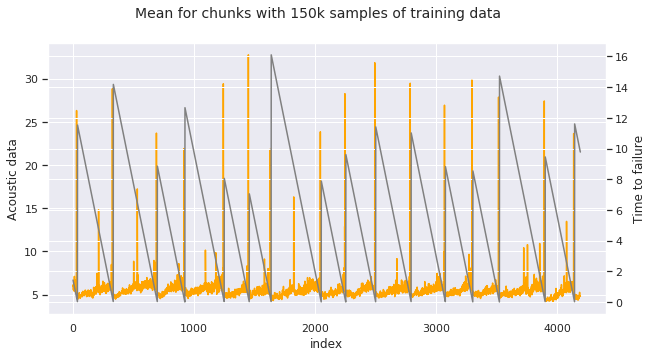

In [26]:
rolling_mean = []
rolling_std = []
last_time = []
init_idx = 0
for _ in range(4194):  # 629M / 150k = 4194
    x = train.iloc[init_idx:init_idx + 150000]
    last_time.append(x.time_to_failure.values[-1])
    rolling_mean.append(x.acoustic_data.abs().mean())
    rolling_std.append(x.acoustic_data.abs().std())
    init_idx += 150000
    
rolling_mean = np.array(rolling_mean)
last_time = np.array(last_time)

# plot rolling mean
fig, ax1 = plt.subplots(figsize=(10, 5))
fig.suptitle('Mean for chunks with 150k samples of training data', fontsize=14)

ax2 = ax1.twinx()
ax1.set_xlabel('index')
ax1.set_ylabel('Acoustic data')
ax2.set_ylabel('Time to failure')
p1 = sns.lineplot(data=rolling_mean, ax=ax1, color='orange')
p2 = sns.lineplot(data=last_time, ax=ax2, color='gray')

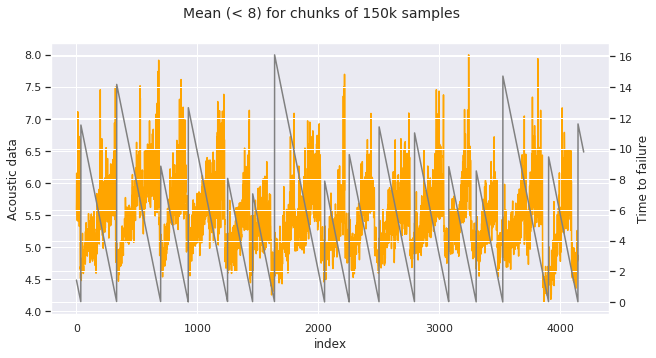

In [27]:
# plot rolling mean
fig, ax1 = plt.subplots(figsize=(10, 5))
fig.suptitle('Mean (< 8) for chunks of 150k samples', fontsize=14)

ax2 = ax1.twinx()
ax1.set_xlabel('index')
ax1.set_ylabel('Acoustic data')
ax2.set_ylabel('Time to failure')
p1 = sns.lineplot(data=rolling_mean[rolling_mean < 8], ax=ax1, color='orange')
p2 = sns.lineplot(data=last_time, ax=ax2, color='gray')

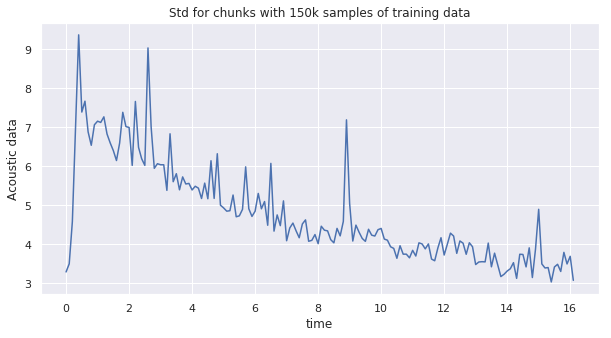

In [30]:
frame = pd.DataFrame({'rolling_std': rolling_std, 'time': np.around(last_time, 1)})
s = frame.groupby('time').rolling_std.mean()
s = s[s < 20]  # remove one outlier
plt.figure(figsize=(10, 5))
plt.title("Std for chunks with 150k samples of training data")
plt.xlabel("Time to failure")
plt.ylabel("Acoustic data")
ax = sns.lineplot(x=s.index, y=s.values)

<h2>2. Feature Engineering</h2>

Simple trend feature: fit a linear regression and return the coefficient

In [8]:
def add_trend_feature(arr, abs_values=False):
    idx = np.array(range(len(arr)))
    if abs_values:
        arr = np.abs(arr)
    lr = LinearRegression()
    lr.fit(idx.reshape(-1, 1), arr)
    return lr.coef_[0]

Group the training data in chunks of 150,000 examples and extract the following features:

* Aggregations: min, max, mean and std
* Absolute features: max, mean and std
* Quantile features
* Trend features
* Rolling features
* Ratios

In [9]:
rows = 150_000
segments = int(np.floor(train.shape[0] / rows))

X_train = pd.DataFrame(index=range(segments), dtype=np.float64)
y_train = pd.DataFrame(index=range(segments), dtype=np.float64)

for segment in tqdm(range(segments)):
    seg = train.iloc[segment*rows:segment*rows+rows]
    x = seg['acoustic_data']   # pd series
    y = seg['time_to_failure'].values[-1]  # single value
    
    y_train.loc[segment, 'time_to_failure'] = y
    
    X_train.loc[segment, 'ave'] = x.values.mean()
    X_train.loc[segment, 'std'] = x.values.std()
    X_train.loc[segment, 'max'] = x.values.max()
    X_train.loc[segment, 'min'] = x.values.min()
    X_train.loc[segment, 'q90'] = np.quantile(x.values, 0.90)
    X_train.loc[segment, 'q95'] = np.quantile(x.values, 0.95)
    X_train.loc[segment, 'q99'] = np.quantile(x.values, 0.99)
    X_train.loc[segment, 'q05'] = np.quantile(x.values, 0.05)
    X_train.loc[segment, 'q10'] = np.quantile(x.values, 0.10)
    X_train.loc[segment, 'q01'] = np.quantile(x.values, 0.01)
    
    X_train.loc[segment, 'abs_max'] = np.abs(x.values).max()
    X_train.loc[segment, 'abs_mean'] = np.abs(x.values).mean()
    X_train.loc[segment, 'abs_std'] = np.abs(x.values).std()
    X_train.loc[segment, 'trend'] = add_trend_feature(x.values)
    X_train.loc[segment, 'abs_trend'] = add_trend_feature(x.values, abs_values=True)
    
    # New features - rolling features
    for w in [10, 50, 100, 1000]:
        x_roll_std = x.rolling(w).std().dropna().values
        x_roll_mean = x.rolling(w).mean().dropna().values
        x_roll_abs_mean = x.abs().rolling(w).mean().dropna().values
        
        X_train.loc[segment, 'ave_roll_std_' + str(w)] = x_roll_std.mean()
        X_train.loc[segment, 'std_roll_std_' + str(w)] = x_roll_std.std()
        X_train.loc[segment, 'max_roll_std_' + str(w)] = x_roll_std.max()
        X_train.loc[segment, 'min_roll_std_' + str(w)] = x_roll_std.min()
        X_train.loc[segment, 'q01_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.01)
        X_train.loc[segment, 'q05_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.05)
        X_train.loc[segment, 'q10_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.10)
        X_train.loc[segment, 'q95_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.95)
        X_train.loc[segment, 'q99_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.99)
        
        X_train.loc[segment, 'ave_roll_mean_' + str(w)] = x_roll_mean.mean()
        X_train.loc[segment, 'std_roll_mean_' + str(w)] = x_roll_mean.std()
        X_train.loc[segment, 'max_roll_mean_' + str(w)] = x_roll_mean.max()
        X_train.loc[segment, 'min_roll_mean_' + str(w)] = x_roll_mean.min()
        X_train.loc[segment, 'q01_roll_mean_' + str(w)] = np.quantile(x_roll_mean, 0.01)
        X_train.loc[segment, 'q05_roll_mean_' + str(w)] = np.quantile(x_roll_mean, 0.05)
        X_train.loc[segment, 'q95_roll_mean_' + str(w)] = np.quantile(x_roll_mean, 0.95)
        X_train.loc[segment, 'q99_roll_mean_' + str(w)] = np.quantile(x_roll_mean, 0.99)
        
        X_train.loc[segment, 'ave_roll_abs_mean_' + str(w)] = x_roll_abs_mean.mean()
        X_train.loc[segment, 'std_roll_abs_mean_' + str(w)] = x_roll_abs_mean.std()
        X_train.loc[segment, 'max_roll_abs_mean_' + str(w)] = x_roll_abs_mean.max()
        X_train.loc[segment, 'min_roll_abs_mean_' + str(w)] = x_roll_abs_mean.min()
        X_train.loc[segment, 'q01_roll_abs_mean_' + str(w)] = np.quantile(x_roll_abs_mean, 0.01)
        X_train.loc[segment, 'q05_roll_abs_mean_' + str(w)] = np.quantile(x_roll_abs_mean, 0.05)
        X_train.loc[segment, 'q95_roll_abs_mean_' + str(w)] = np.quantile(x_roll_abs_mean, 0.95)
        X_train.loc[segment, 'q99_roll_abs_mean_' + str(w)] = np.quantile(x_roll_abs_mean, 0.99)

In [10]:
print("Train shape:", X_train.shape)
X_train.head(3)

Train shape: (4194, 115)


,ave,std,max,min,q90,q95,q99,q05,q10,q01,...,q95_roll_mean_1000,q99_roll_mean_1000,ave_roll_abs_mean_1000,std_roll_abs_mean_1000,max_roll_abs_mean_1000,min_roll_abs_mean_1000,q01_roll_abs_mean_1000,q05_roll_abs_mean_1000,q95_roll_abs_mean_1000,q99_roll_abs_mean_1000
0,4.884113,5.101089,104.0,-98.0,10.0,11.0,18.0,-2.0,0.0,-8.0,...,5.338,5.484,5.579118,1.612370,24.851,4.110,4.340,4.589,7.518,11.487
1,4.725767,6.588802,181.0,-154.0,10.0,12.0,21.0,-2.0,0.0,-11.0,...,5.066,5.223,5.739510,2.399157,28.410,4.325,4.447,4.552,8.552,20.504
2,4.906393,6.967374,140.0,-106.0,10.0,13.0,26.0,-3.0,0.0,-15.0,...,5.344,5.486,6.159850,2.414414,26.940,4.394,4.513,4.717,10.959,16.539


Scale features and helper functions:

In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
target = y_train.values.flatten()
num_folds = 5

def grid_search_cv(estimator, grid, features, target):
    """Return the best hyperparameters combination in grid."""
    t0 = time.time()
    reg = GridSearchCV(estimator, grid, cv=num_folds, scoring='neg_mean_absolute_error')
    reg.fit(features, target)
    
    t0 = time.time() - t0
    print("Best CV score: {:.4f}, time: {:.1f}s".format(-reg.best_score_, t0))
    print(reg.best_params_)
    return reg.best_params_

def make_predictions(estimator, features, target, test=None, plot=True, lgb=False):
    """Train the estimator and make predictions for oof and test data."""
    folds = KFold(num_folds, shuffle=True, random_state=2019)
    oof_predictions = np.zeros(features.shape[0])
    if test is not None:
        sub_predictions = np.zeros(test.shape[0])
    for (train_index, valid_index) in folds.split(features, target):
        
        if lgb:
            estimator.fit(features[train_index], target[train_index],
                          early_stopping_rounds=100, verbose=False,
                          eval_set=[(features[train_index], target[train_index]),
                                    (features[valid_index], target[valid_index])])
        else:
            estimator.fit(features[train_index], target[train_index])
        oof_predictions[valid_index] = estimator.predict(features[valid_index]).flatten()
        if test is not None:
            sub_predictions += estimator.predict(test).flatten() / num_folds
    
    # Plot out-of-fold predictions vs actual values
    if plot:
        fig, axis = plt.subplots(1, 2, figsize=(12,5))
        ax1, ax2 = axis
        ax1.set_xlabel('actual')
        ax1.set_ylabel('predicted')
        ax2.set_xlabel('train index')
        ax2.set_ylabel('time to failure')
        ax1.scatter(target, oof_predictions, color='brown')
        ax1.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)], color='blue')
        ax2.plot(target, color='blue', label='y_train')
        ax2.plot(oof_predictions, color='orange')
    if test is not None:
        return oof_predictions, sub_predictions
    else:
        return oof_predictions

<h2>3. Models</h2>

Let's try a few different models and submit the one with the best validation score. The predicted values in the following plots are using a out-of-fold scheme.

<h3>Ridge Regression</h3>

The first model will be a linear regression with L2 regularization.



Best CV score: 2.1540, time: 42.7s
{'alpha': 79.88288288288288}


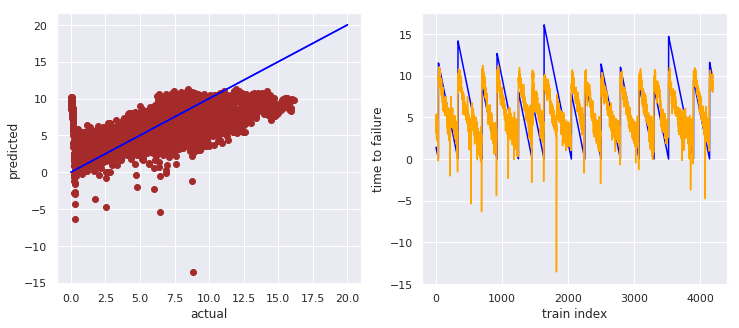

In [12]:
grid = [{'alpha': np.concatenate([np.linspace(0.001, 1, 100), np.linspace(1, 200, 1000)])}]
params = grid_search_cv(Ridge(), grid, X_train_scaled, target)
ridge_oof = make_predictions(Ridge(**params), X_train_scaled, target)

There are some huge negative values when using a linear model. We can try to change negative values for zeros:

In [13]:
ridge_oof[ridge_oof < 0] = 0
print("Mean error: {:.4f}".format(mean_absolute_error(target, ridge_oof)))

Mean error: 2.1116


<h3>Kernel Ridge</h3>

This model combines regularized linear regression with a given kernel (radial basis in this case).

Best CV score: 2.2250, time: 179.6s
{'alpha': 0.1, 'gamma': 0.01111112}


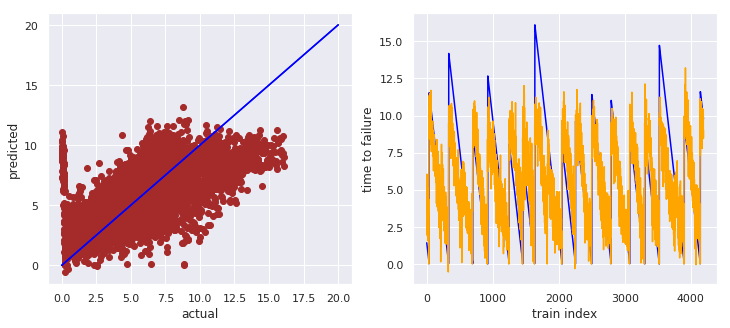

In [14]:
grid = [{'gamma': np.linspace(1e-8, 0.1, 10), 'alpha': [0.0005, 0.001, 0.02, 0.08, 0.1]}]
params = grid_search_cv(KernelRidge(kernel='rbf'), grid, X_train_scaled, target)
kr_oof = make_predictions(KernelRidge(kernel='rbf', **params), X_train_scaled, target)

<h3>SVM</h3>
Support vector machine with radial basis function kernel.

Best CV score: 2.1266, time: 1334.6s
{'C': 0.23111111111111113, 'epsilon': 0.5}


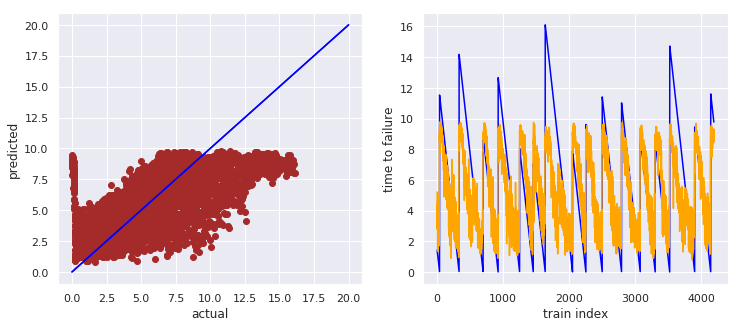

In [15]:
grid = [{'epsilon': np.linspace(0.01, 0.5, 10), 'C': np.linspace(0.01, 2, 10)}]
params = grid_search_cv(SVR(kernel='rbf', gamma='scale'), grid, X_train_scaled, target)
svm_oof = make_predictions(SVR(kernel='rbf', gamma='scale', **params, njobs=4), X_train_scaled, target)

<h3>Random Forests</h3>

This regressor fits many decision trees with different subsets of the original data and average the predictions between them.

Best CV score: 2.1722, time: 1593.3s
{'max_depth': 8, 'max_features': 'sqrt'}


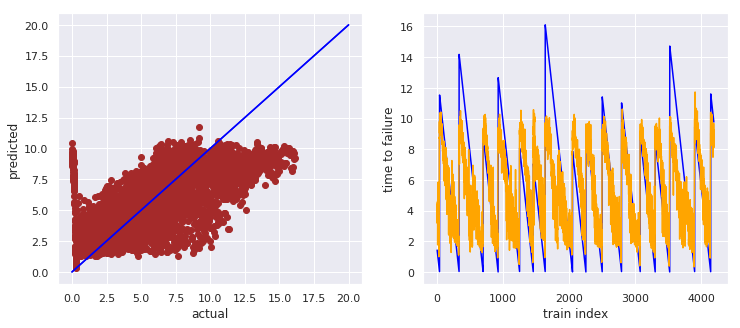

In [17]:
grid = [{
    'max_depth': [8, 10, 12],
    'max_features': ['auto', 'sqrt', 'log2'],
    #'min_samples_leaf': [2, 4, 12],
    #'min_samples_split': [2, 6, 12],
}]


params = grid_search_cv(RandomForestRegressor(criterion='mae', n_estimators=50),
                        grid, X_train_scaled, target)
rf_oof = make_predictions(RandomForestRegressor(criterion='mae', n_estimators=200, **params, n_jobs=4),
                          X_train_scaled, target)

<h3>Extremely Randomized Trees</h3>

Best CV score: 2.1764, time: 691.3s
{'max_depth': 12, 'max_features': 'sqrt'}


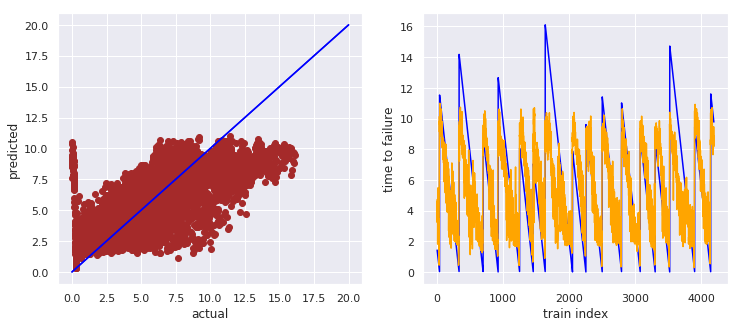

In [18]:
params = grid_search_cv(ExtraTreesRegressor(criterion='mae', n_estimators=50),
                        grid, X_train_scaled, target)
ex_oof = make_predictions(ExtraTreesRegressor(criterion='mae', n_estimators=200, **params),
                          X_train_scaled, target)

<h3>Ada Boost</h3>

AdaBoost begins by fitting a base estimator on the original dataset and then fits additional copies on the same dataset. At each iteration (estimator), the weights of instances are adjusted according to the error of the last prediction. It's similar to the next model, but gradient boosting fits additional estimator copies on the current error and not on the original dataset.

Best CV score: 2.1716, time: 32.0s
{'learning_rate': 0.01}


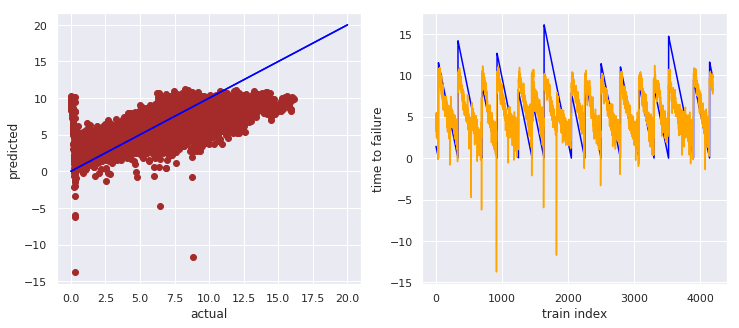

In [19]:
grid = [{'learning_rate': np.linspace(0.01, 0.1, 10)}]
#base = DecisionTreeRegressor(max_depth=5)
base = Ridge(alpha=10)
params = grid_search_cv(AdaBoostRegressor(base_estimator=base, n_estimators=100),
                        grid, X_train_scaled, target)
ada_oof = make_predictions(AdaBoostRegressor(base_estimator=base, n_estimators=100, **params),
                           X_train_scaled, target)

<h3>Gradient Boosting</h3>

The last model is a gradient boosting decision tree. It's not possible to use GridSearchCV with early stopping (lightgbm), so I am using a custom function for random search.

In [20]:
fixed_params = {
    'objective': 'regression_l1',
    'boosting': 'gbdt',
    'verbosity': -1,
    'random_seed': 19,
    'n_estimators': 20000,
}

param_grid = {
    'learning_rate': [0.1, 0.05, 0.01, 0.005],
    'num_leaves': list(range(8, 92, 4)),
    'max_depth': [3, 4, 5, 6, 8, 12, 16, -1],
    'feature_fraction': [0.8, 0.85, 0.9, 0.95, 1],
    'subsample': [0.8, 0.85, 0.9, 0.95, 1],
    'lambda_l1': [0, 0.1, 0.2, 0.4, 0.6, 0.9],
    'lambda_l2': [0, 0.1, 0.2, 0.4, 0.6, 0.9],
    'min_data_in_leaf': [10, 20, 40, 60, 100],
    'min_gain_to_split': [0, 0.001, 0.01, 0.1],
}

best_score = 999
dataset = lgb.Dataset(X_train, label=y_train)  # no need to scale features

for i in range(500):
    params = {k: random.choice(v) for k, v in param_grid.items()}
    params.update(fixed_params)
    result = lgb.cv(params, dataset, nfold=5, early_stopping_rounds=100,
                    stratified=False)
    
    if result['l1-mean'][-1] < best_score:
        best_score = result['l1-mean'][-1]
        best_params = params
        best_nrounds = len(result['l1-mean'])

Best mean score: 2.0097, num rounds: 2149
{'learning_rate': 0.005, 'num_leaves': 12, 'max_depth': 4, 'feature_fraction': 0.8, 'subsample': 0.85, 'lambda_l1': 0.9, 'lambda_l2': 0, 'min_data_in_leaf': 40, 'min_gain_to_split': 0.001, 'objective': 'regression_l1', 'boosting': 'gbdt', 'verbosity': -1, 'random_seed': 19, 'n_estimators': 20000}


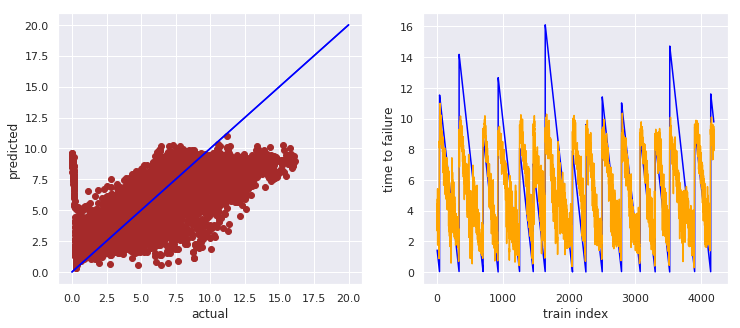

In [21]:
print("Best mean score: {:.4f}, num rounds: {}".format(best_score, best_nrounds))
print(best_params)
gb_oof = make_predictions(lgb.LGBMRegressor(**best_params), X_train.values, target, lgb=True)

Now let's have a look at the <b>feature importance</b>:

In [22]:
def plot_feature_importance(features, target, columns):
    folds = KFold(num_folds, shuffle=True, random_state=2019)
    importance_frame = pd.DataFrame()
    for (train_index, valid_index) in folds.split(features, target):
        reg = lgb.LGBMRegressor(**best_params)
        reg.fit(features[train_index], target[train_index],
                early_stopping_rounds=100, verbose=False,
                eval_set=[(features[train_index], target[train_index]),
                          (features[valid_index], target[valid_index])])
        fold_importance = pd.DataFrame()
        fold_importance["feature"] = columns
        fold_importance["gain"] = reg.booster_.feature_importance(importance_type='gain')
        #fold_importance["split"] = reg.booster_.feature_importance(importance_type='split')
        importance_frame = pd.concat([importance_frame, fold_importance], axis=0)
        
    mean_importance = importance_frame.groupby('feature').mean().reset_index()
    mean_importance.sort_values(by='gain', ascending=True, inplace=True)
    trace = go.Bar(y=mean_importance.feature, x=mean_importance.gain,
                   orientation='h', marker=dict(color='rgb(49,130,189)'))

    layout = go.Layout(
        title='Feature importance', height=1200, width=800,
        showlegend=False,
        xaxis=dict(
            title='Importance by gain',
            titlefont=dict(size=14, color='rgb(107, 107, 107)'),
            domain=[0.25, 1]
        ),
    )

    fig = go.Figure(data=[trace], layout=layout)
    iplot(fig)
    
plot_feature_importance(X_train.values, target, X_train.columns)

<h2>4. Test data and submission</h2>

In [47]:
submission = pd.read_csv('sample_submission.csv', index_col='seg_id')
X_test = pd.DataFrame(columns=X_train.columns, dtype=np.float64, index=submission.index)

In [48]:
for seg_id in X_test.index:
    seg = pd.read_csv('test/' + seg_id + '.csv')
    
    x = seg['acoustic_data']  # pd series
    
    X_test.loc[seg_id, 'ave'] = x.values.mean()
    X_test.loc[seg_id, 'std'] = x.values.std()
    X_test.loc[seg_id, 'max'] = x.values.max()
    X_test.loc[seg_id, 'min'] = x.values.min()
    X_test.loc[seg_id, 'q90'] = np.quantile(x.values, 0.90)
    X_test.loc[seg_id, 'q95'] = np.quantile(x.values, 0.95)
    X_test.loc[seg_id, 'q99'] = np.quantile(x.values, 0.99)
    X_test.loc[seg_id, 'q05'] = np.quantile(x.values, 0.05)
    X_test.loc[seg_id, 'q10'] = np.quantile(x.values, 0.10)
    X_test.loc[seg_id, 'q01'] = np.quantile(x.values, 0.01)
    
    X_test.loc[seg_id, 'abs_max'] = np.abs(x.values).max()
    X_test.loc[seg_id, 'abs_mean'] = np.abs(x.values).mean()
    X_test.loc[seg_id, 'abs_std'] = np.abs(x.values).std()
    X_test.loc[seg_id, 'trend'] = add_trend_feature(x.values)
    X_test.loc[seg_id, 'abs_trend'] = add_trend_feature(x.values, abs_values=True)
    
    # New features - rolling features
    for w in [10, 50, 100, 1000]:
        x_roll_std = x.rolling(w).std().dropna().values
        x_roll_mean = x.rolling(w).mean().dropna().values
        x_roll_abs_mean = x.abs().rolling(w).mean().dropna().values
        
        X_test.loc[seg_id, 'ave_roll_std_' + str(w)] = x_roll_std.mean()
        X_test.loc[seg_id, 'std_roll_std_' + str(w)] = x_roll_std.std()
        X_test.loc[seg_id, 'max_roll_std_' + str(w)] = x_roll_std.max()
        X_test.loc[seg_id, 'min_roll_std_' + str(w)] = x_roll_std.min()
        X_test.loc[seg_id, 'q01_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.01)
        X_test.loc[seg_id, 'q05_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.05)
        X_test.loc[seg_id, 'q10_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.10)
        X_test.loc[seg_id, 'q95_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.95)
        X_test.loc[seg_id, 'q99_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.99)
        
        X_test.loc[seg_id, 'ave_roll_mean_' + str(w)] = x_roll_mean.mean()
        X_test.loc[seg_id, 'std_roll_mean_' + str(w)] = x_roll_mean.std()
        X_test.loc[seg_id, 'max_roll_mean_' + str(w)] = x_roll_mean.max()
        X_test.loc[seg_id, 'min_roll_mean_' + str(w)] = x_roll_mean.min()
        X_test.loc[seg_id, 'q01_roll_mean_' + str(w)] = np.quantile(x_roll_mean, 0.01)
        X_test.loc[seg_id, 'q05_roll_mean_' + str(w)] = np.quantile(x_roll_mean, 0.05)
        X_test.loc[seg_id, 'q95_roll_mean_' + str(w)] = np.quantile(x_roll_mean, 0.95)
        X_test.loc[seg_id, 'q99_roll_mean_' + str(w)] = np.quantile(x_roll_mean, 0.99)
        
        X_test.loc[seg_id, 'ave_roll_abs_mean_' + str(w)] = x_roll_abs_mean.mean()
        X_test.loc[seg_id, 'std_roll_abs_mean_' + str(w)] = x_roll_abs_mean.std()
        X_test.loc[seg_id, 'max_roll_abs_mean_' + str(w)] = x_roll_abs_mean.max()
        X_test.loc[seg_id, 'min_roll_abs_mean_' + str(w)] = x_roll_abs_mean.min()
        X_test.loc[seg_id, 'q01_roll_abs_mean_' + str(w)] = np.quantile(x_roll_abs_mean, 0.01)
        X_test.loc[seg_id, 'q05_roll_abs_mean_' + str(w)] = np.quantile(x_roll_abs_mean, 0.05)
        X_test.loc[seg_id, 'q95_roll_abs_mean_' + str(w)] = np.quantile(x_roll_abs_mean, 0.95)
        X_test.loc[seg_id, 'q99_roll_abs_mean_' + str(w)] = np.quantile(x_roll_abs_mean, 0.99)

Using predictions from the model with the highest validation score (gradient boosting):

In [49]:
gb_oof, gb_sub = make_predictions(lgb.LGBMRegressor(**best_params),
                                  X_train.values, target, X_test,
                                  plot=False, lgb=True)
submission['time_to_failure'] = gb_sub
submission.to_csv('submission_gb.csv')
submission.head()

,time_to_failure
seg_id,
seg_00030f,3.07985660
seg_0012b5,5.34691490
seg_00184e,5.76738979
seg_003339,7.49619357
seg_0042cc,6.99752272
